## Reading mitab data from psicquic
* [Requests API](https://requests.readthedocs.io/en/master/)

In [1]:
proxies = {
  'http': 'http://ftprox.ibcp.fr:3128',
  'https': 'http://ftprox.ibcp.fr:3128',
}

In [1]:
import requests

psicquicProviderURL="http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search"
miqlMethod="query"
miqlField="pubid"
miqlValue="17446270"

miqlRequest= f"{psicquicProviderURL}/{miqlMethod}/{miqlField}:{miqlValue}"

print(miqlRequest)

try:
    httpReq = requests.get(miqlRequest, proxies=proxies)
except NameError:
    httpReq = requests.get(miqlRequest)

ans = httpReq.text

http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270


In [2]:
psqData = [ _.split("\t") for _ in ans.split("\n") if len(_.split("\t")) > 1]
    
_ = len(psqData[0])
for psqDatum in psqData:
    assert len(psqDatum) == _
print(f"Total number of interaction data {len(psqData)}")

# Remove all psicquic entry not mapped to a uniprot ID
psqData = [ ok for ok in filter( lambda x:x[0].startswith("uniprotkb:") and x[1].startswith("uniprotkb:"), psqData ) ]

psqData[-1]


Total number of interaction data 232


['uniprotkb:P0C722',
 'uniprotkb:Q12933',
 'intact:EBI-2623029|uniprotkb:Q777E3',
 'intact:EBI-355744|uniprotkb:A8K107|uniprotkb:B4DPJ7|uniprotkb:Q7Z337|dip:DIP-6223N|intact:EBI-1046651|uniprotkb:Q96NT2',
 'psi-mi:brrf1_ebvg(display_long)|uniprotkb:BRRF1(orf name)',
 'psi-mi:traf2_human(display_long)|uniprotkb:Tumor necrosis factor type 2 receptor-associated protein 3(gene name synonym)|uniprotkb:E3 ubiquitin-protein ligase TRAF2(gene name synonym)|uniprotkb:RING-type E3 ubiquitin transferase TRAF2(gene name synonym)|uniprotkb:TRAF2(gene name)|psi-mi:TRAF2(display_short)|uniprotkb:TRAP3(gene name synonym)',
 'psi-mi:"MI:0018"(two hybrid)',
 'Calderwood et al. (2007)',
 'pubmed:17446270|imex:IM-20435|mint:MINT-6769080',
 'taxid:10376(ebvg)|taxid:10376("Epstein-Barr virus (strain B95-8)")',
 'taxid:9606(human)|taxid:9606(Homo sapiens)',
 'psi-mi:"MI:0915"(physical association)',
 'psi-mi:"MI:0469"(IntAct)',
 'intact:EBI-2644156|imex:IM-20435-230',
 'intact-miscore:0.37']

### Separate EBV-EBV and EBV-Human interactomes

In [3]:
import networkx as nx
import re

reEBV   = "taxid:(1037[6-7]|82830)"
reHuman = "taxid:9606"
EBV_psqData      = []
HumanEBV_psqData = []

G = nx.Graph()

for psqDatum in psqData:
    if re.search(reEBV, psqDatum[9]) and re.search(reEBV, psqDatum[10]):
        G.add_edge(psqDatum[0].replace("uniprotkb:", ""), psqDatum[1].replace("uniprotkb:", "") )
        EBV_psqData.append(psqDatum)
    else:
        HumanEBV_psqData.append(psqDatum)

print(f" EBV-EBV interaction count {len(HumanEBV_psqData)} // EBV-Human interaction count {len(EBV_psqData)}")


 EBV-EBV interaction count 171 // EBV-Human interaction count 59


### Draw EBV-EBV PPI network
* Labeled with uniprotID
* [NetworkX Draw](https://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx)

In [4]:
%matplotlib nbagg
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


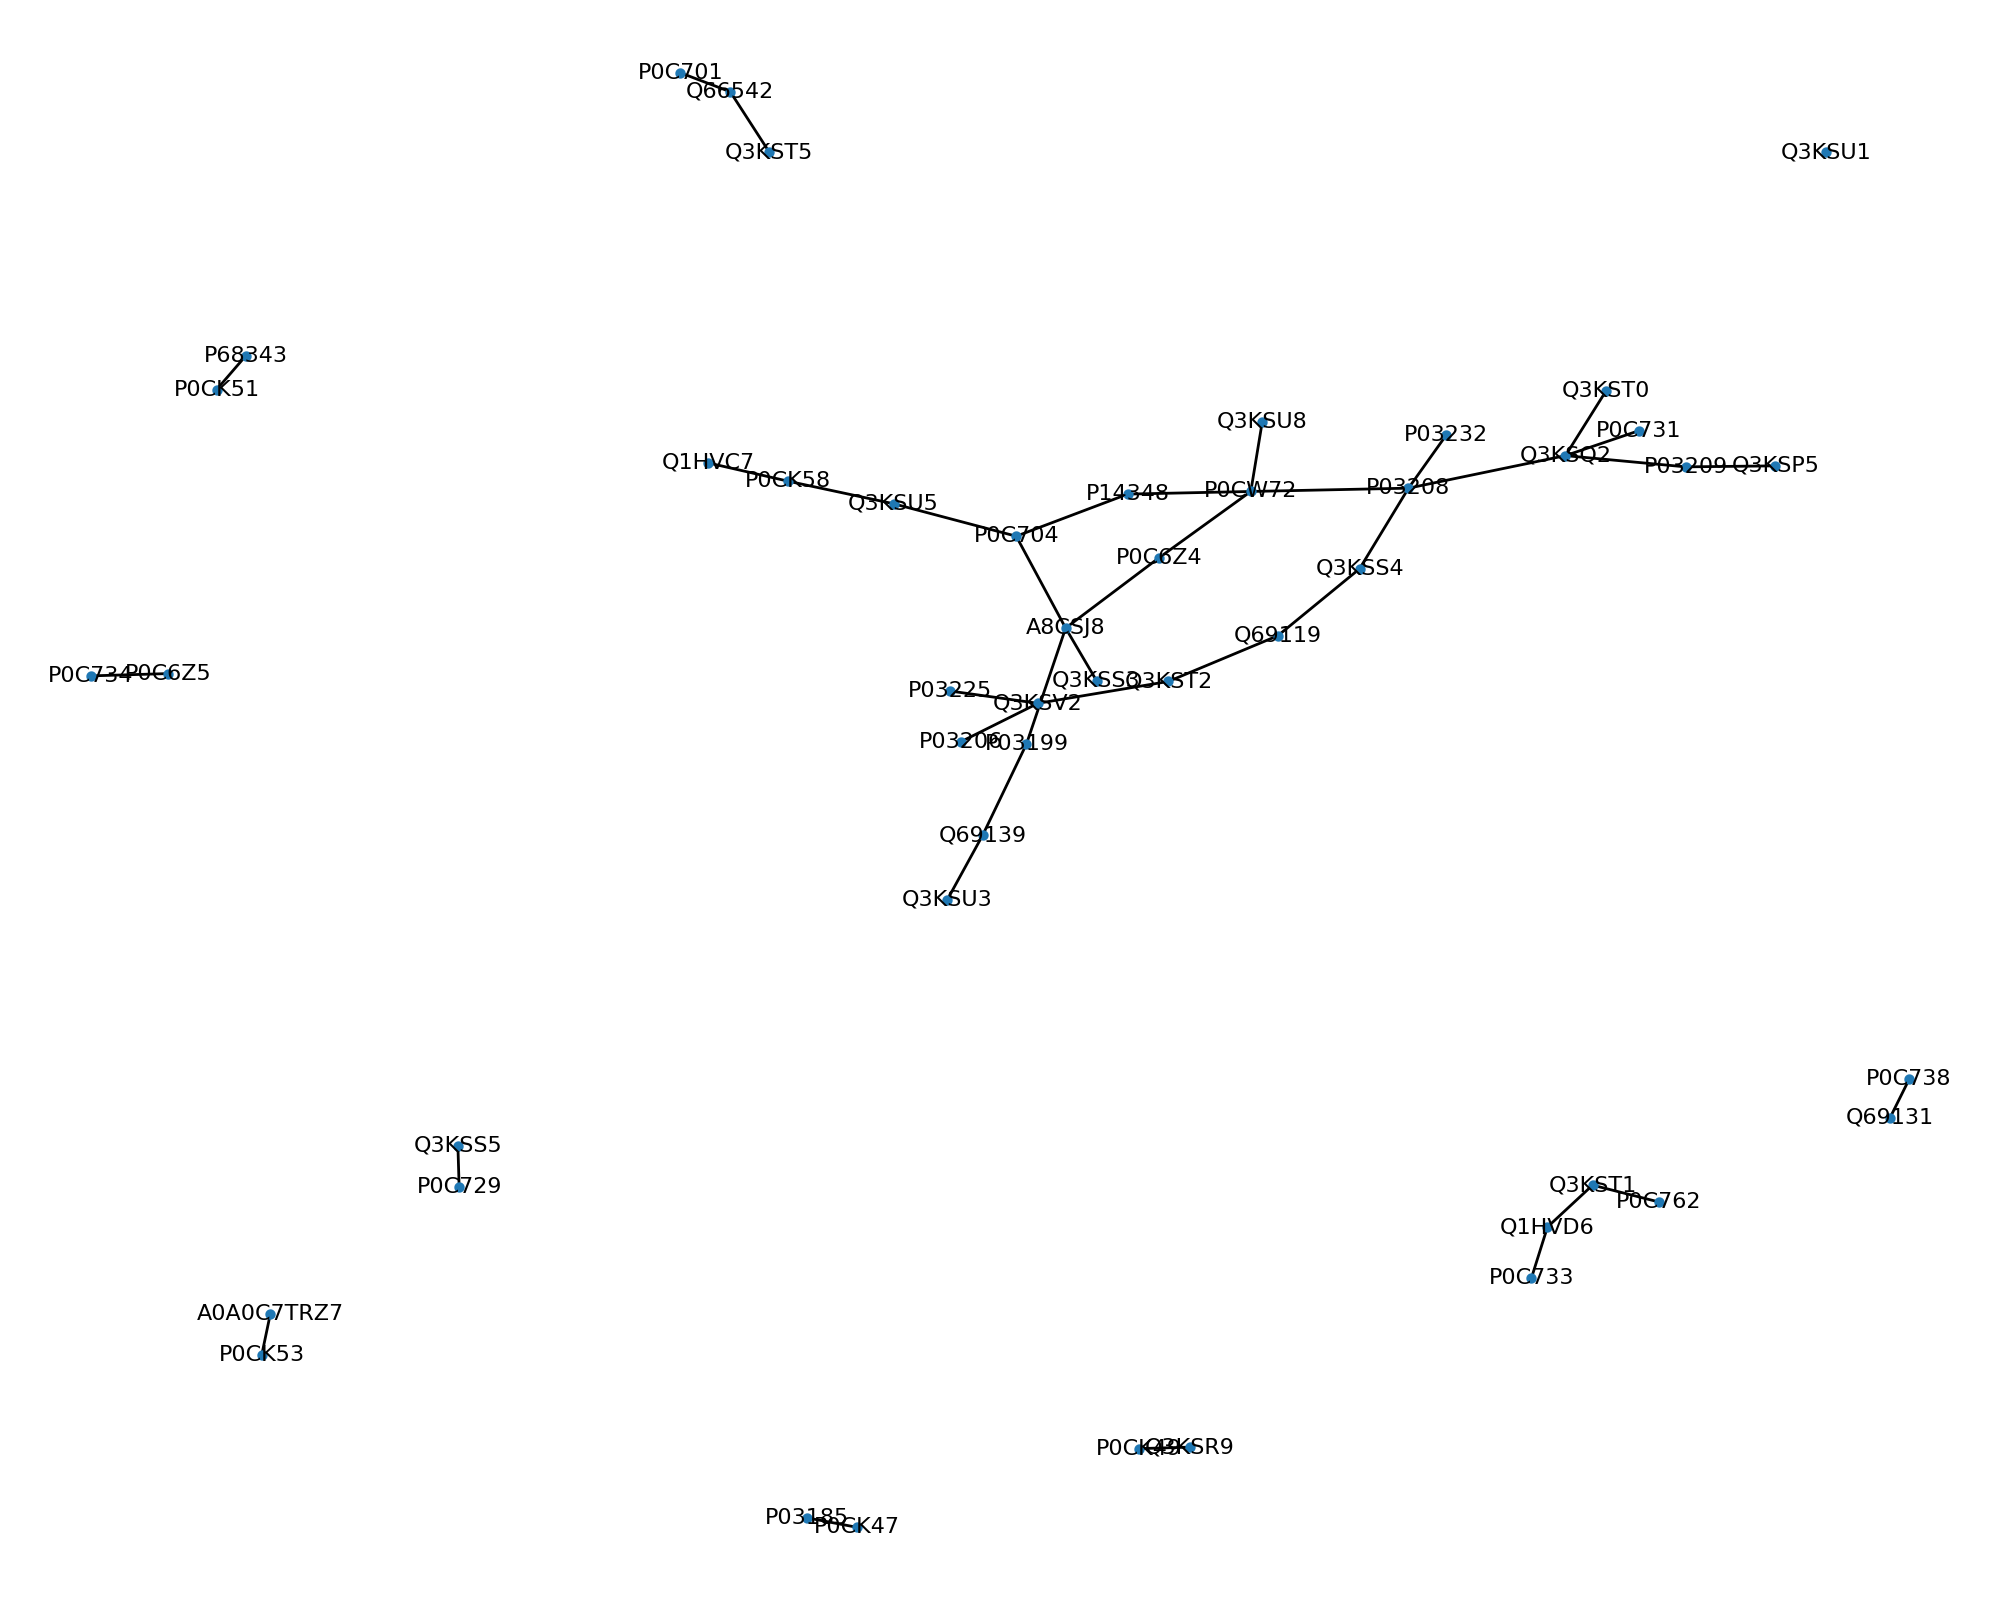

In [5]:
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=3, font_size=8, linewidths=2)

#### Draw EBV-EBV PPI network
* Labeled with gene Name
* Information provider: `./data/Calderwood_EBV_proteome.xml`
* [NetworkX Draw](https://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx)

In [6]:
# Parameters: uniprotID{String}, root{xmlNode}
# Returns: GeneName{String}|Default:uniprotID{String}
def geneName(uniprotID, root):
    ns = '{http://uniprot.org/uniprot}' 
    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID:
                gene = entry.find(ns+"gene")
                if not gene:
                    return uniprotID
                name = gene.find(ns+"name")
                return name.text
    raise ValueError(uniprotID)

In [7]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree
    
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()    

EBV_EBV_geneLabels = {}
for node in G.nodes():
    EBV_EBV_geneLabels[node] = geneName(node, root)
EBV_EBV_geneLabels

{'P0CW72': 'BARF1',
 'P0C704': 'MCP',
 'P14348': 'SCP',
 'P03185': 'NEC2',
 'P0CK47': 'NEC1',
 'P0C731': 'BGLF4',
 'Q3KSQ2': 'TK',
 'P0CK53': 'BGLF2',
 'A0A0C7TRZ7': 'BSLF1',
 'Q3KST5': 'BLRF2',
 'Q66542': 'BNRF1',
 'Q3KSS4': 'EBNA1',
 'P03209': 'BRLF1',
 'Q3KSP5': 'LF2',
 'Q3KSU8': 'BPLF1',
 'Q3KSU1': 'BMLF1',
 'Q3KSV2': 'EBNA2',
 'P03206': 'BZLF1',
 'Q3KST2': 'EBNA3',
 'P03225': 'BDLF2',
 'Q3KSU5': 'RIR1',
 'P0C729': 'LMP2',
 'Q3KSS5': 'BRRF2',
 'Q69119': 'Q69119',
 'Q3KST0': 'EBNA6',
 'P0CK58': 'BALF1',
 'P03208': 'BILF1',
 'Q69131': 'BN-LF2a',
 'P0C738': 'BNLF2a',
 'P0C701': 'RIR2',
 'Q1HVC7': 'BVRF2',
 'P0CK49': 'BSRF1',
 'Q3KSR9': 'BBRF1',
 'P0C734': 'BTRF1',
 'P0C6Z5': 'BZLF2',
 'Q3KSS3': 'gL',
 'A8CSJ8': 'LMP1',
 'P68343': 'BLLF1',
 'P0CK51': 'BBLF1',
 'P03199': 'BLLF2',
 'Q69139': 'Q69139',
 'P0C6Z4': 'gN',
 'Q3KSU3': 'BMRF1',
 'P03232': 'BXRF1',
 'Q3KST1': 'EBNA4',
 'P0C762': 'gB',
 'P0C733': 'BNLF2b',
 'Q1HVD6': 'TRX2'}

<IPython.core.display.Javascript object>


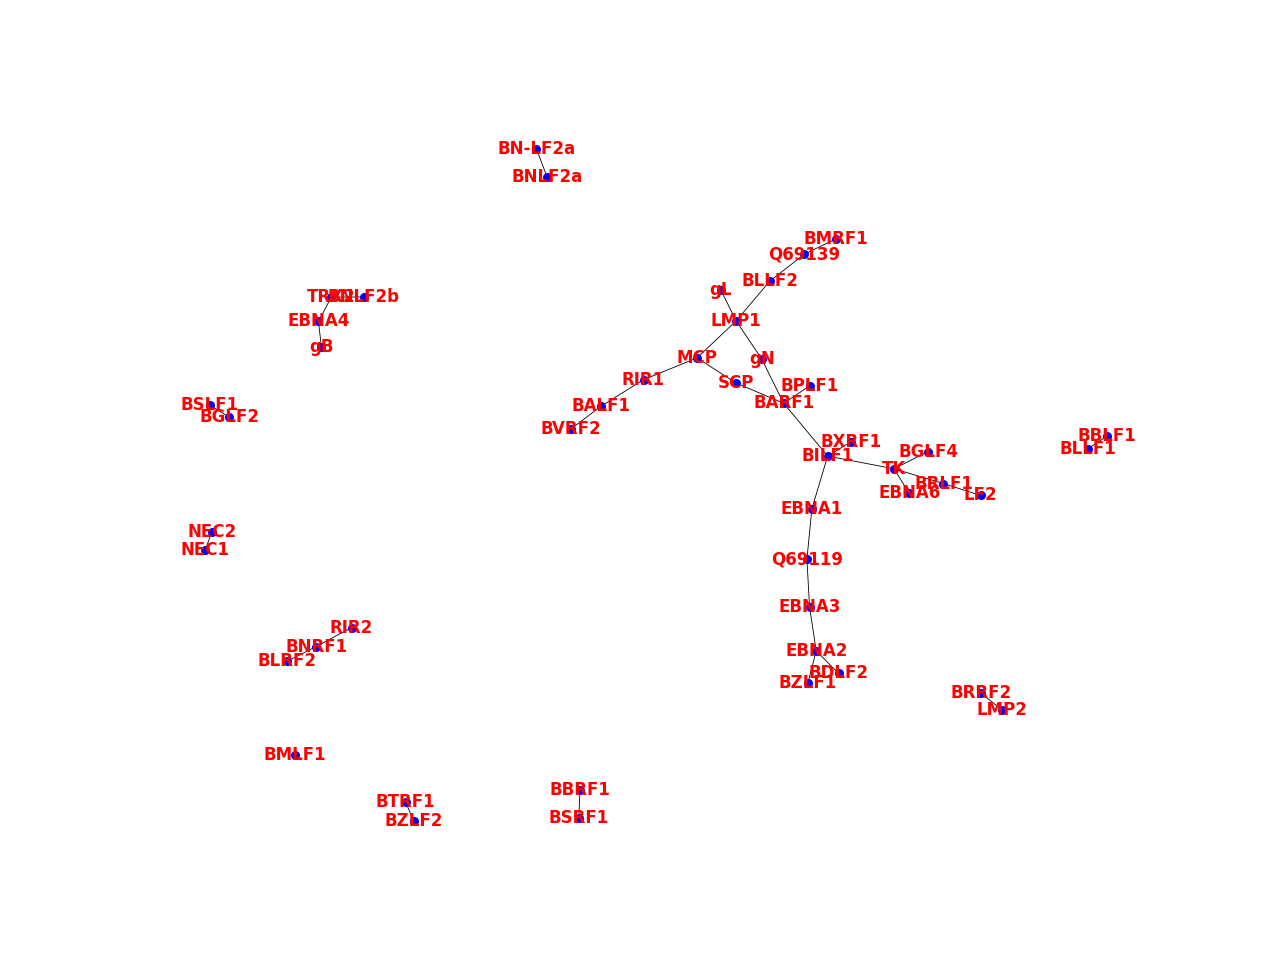

In [8]:
plt.figure()
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=5, node_color="blue")
nx.draw_networkx_labels(G,pos,EBV_EBV_geneLabels,font_size=6,font_weight=600,font_color='r')
nx.draw_networkx_edges(G, pos, width=0.3)

### Draw the EBV-human interactome w/ label only on human genes
* Node labeled with gene Name
* Different symbols for human and EBV genes respectively
* Spring layout
* [Bipartite layout](https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html?highlight=bipartite#module-networkx.algorithms.bipartite)

In [10]:
G2 = nx.Graph()
humanGeneLabels = {}
ebvGeneLabels   = {}
EBV_nodeList    = []
for psqDatum in HumanEBV_psqData:
    #print(psqDatum)
    (a, b) = ( psqDatum[0].replace("uniprotkb:", ""), psqDatum[1].replace("uniprotkb:", "") )
    G2.add_edge(a, b)
    (a,b) = (a,b) if re.search(reHuman, psqDatum[9]) else (b,a)
    EBV_nodeList.append(b)
    humanGeneLabels[a] = None
    ebvGeneLabels[b]   = None
    
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()    
for humanID in humanGeneLabels.keys():
    humanGeneLabels[humanID] = geneName(humanID, root)
    
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()    
for ebvID in ebvGeneLabels.keys():
    ebvGeneLabels[ebvID] = geneName(ebvID, root)
#humanGeneLabels


##### Spring layout

<IPython.core.display.Javascript object>


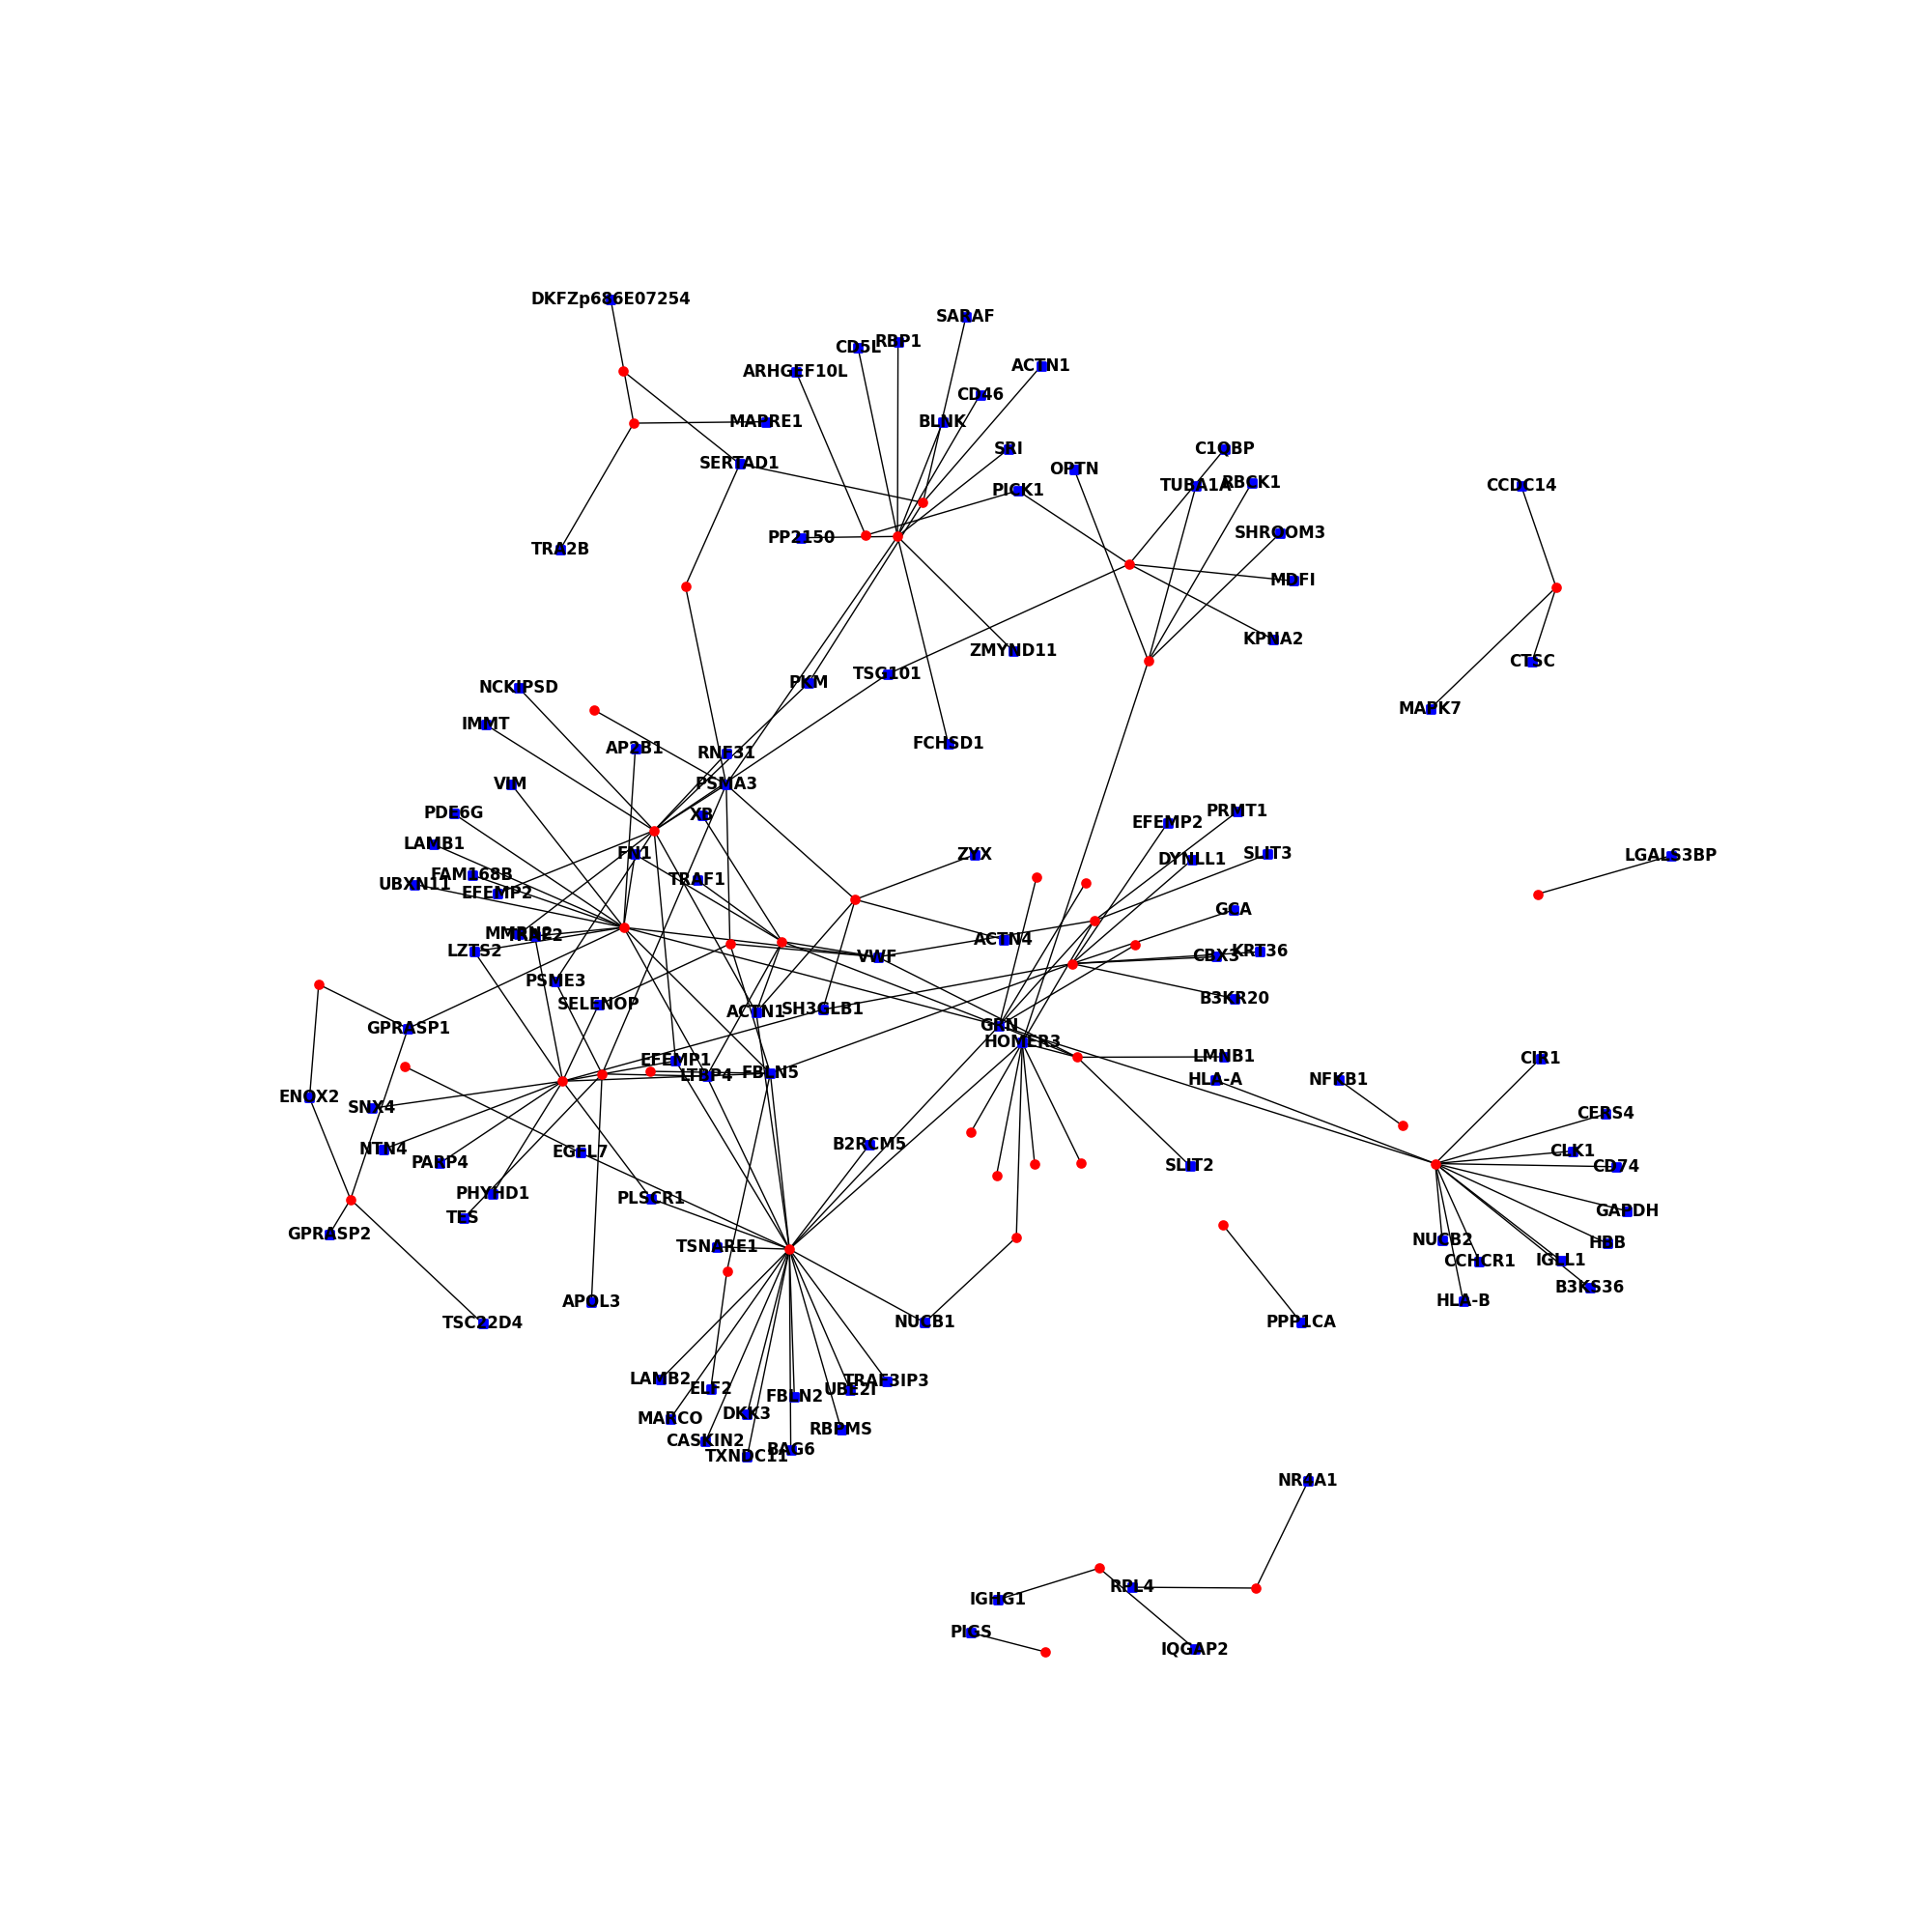

In [56]:
plt.figure(figsize=(10, 10))
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G2, k= 0.225)

nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="blue", node_shape="s",nodelist=humanGeneLabels.keys() )
nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="red", node_shape="o",nodelist=ebvGeneLabels.keys() )
nx.draw_networkx_labels(G2,pos,humanGeneLabels,font_size=6,font_weight=800,font_color='black')
nx.draw_networkx_edges(G2, pos, width=0.5)

[Bipartite](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.bipartite_layout.html)

In [52]:
for n in G2.nodes():
    print(n)

Q9UBX5
Q3KSN9
Q15723
Q9BRK4
P0C762
Q8N2S1
P28799
Q8TAS6
P02751
P63010
P08670
Q12933
P18545
Q5T124
Q5JY77
P04275
P12814
P0C701
Q9UHV2
A1KXE4
Q9HCE6
Q3KSR8
Q9NRD5
Q96BY9
P14618
Q1HVD6
Q49A88
Q9NSC5
Q3KSR7
Q02818
P03225
A4D0U5
Q13164
P53634
P25788
P61289
O95236
A0A0C7TUY8
P03224
P0CK47
P0CK56
Q96IR5
Q12805
P46379
Q8WXE0
Q9Y228
B2RCM5
Q9UEW3
A1L0V1
Q86V58
P63279
O15162
P55268
Q9UHF1
Q6PKC3
Q9UBP4
Q93062
P03185
Q96NA8
Q9BYM8
P0CK53
O75094
Q99873
Q96CV9
Q71U36
P0C736
P0C731
Q13576
P01857
Q8TF72
O95681
P03208
Q13077
O94813
P20700
P03199
P03200
Q3KSS3
Q3KSU7
Q69132
P0C6Z4
Q8TD31
Q3KSU8
P04233
P49759
P04406
P68871
P04439
P01889
Q86X95
B3KS36
P15814
P80303
Q9HA82
P0C722
Q9UKK3
P49908
O95219
Q9Y371
Q5SRE7
Q9HB63
P19838
P03193
P0C734
P62136
Q9NZQ3
P0C706
Q16891
Q99816
Q6FH22
Q9H8L6
Q9Y3Q8
Q3KSQ2
Q96EP0
P03206
Q96D09
Q16206
P03232
Q3KSS4
Q99750
Q07021
Q69114
Q3KSV2
P52292
O43866
Q8WY48
P15529
P30626
Q15326
P09455
Q69022
Q86WN1
Q8WV28
Q13185
P28676
P63167
O95967
O76013
B3KR20
Q3KST2
P22736
P36578
Q6

<IPython.core.display.Javascript object>


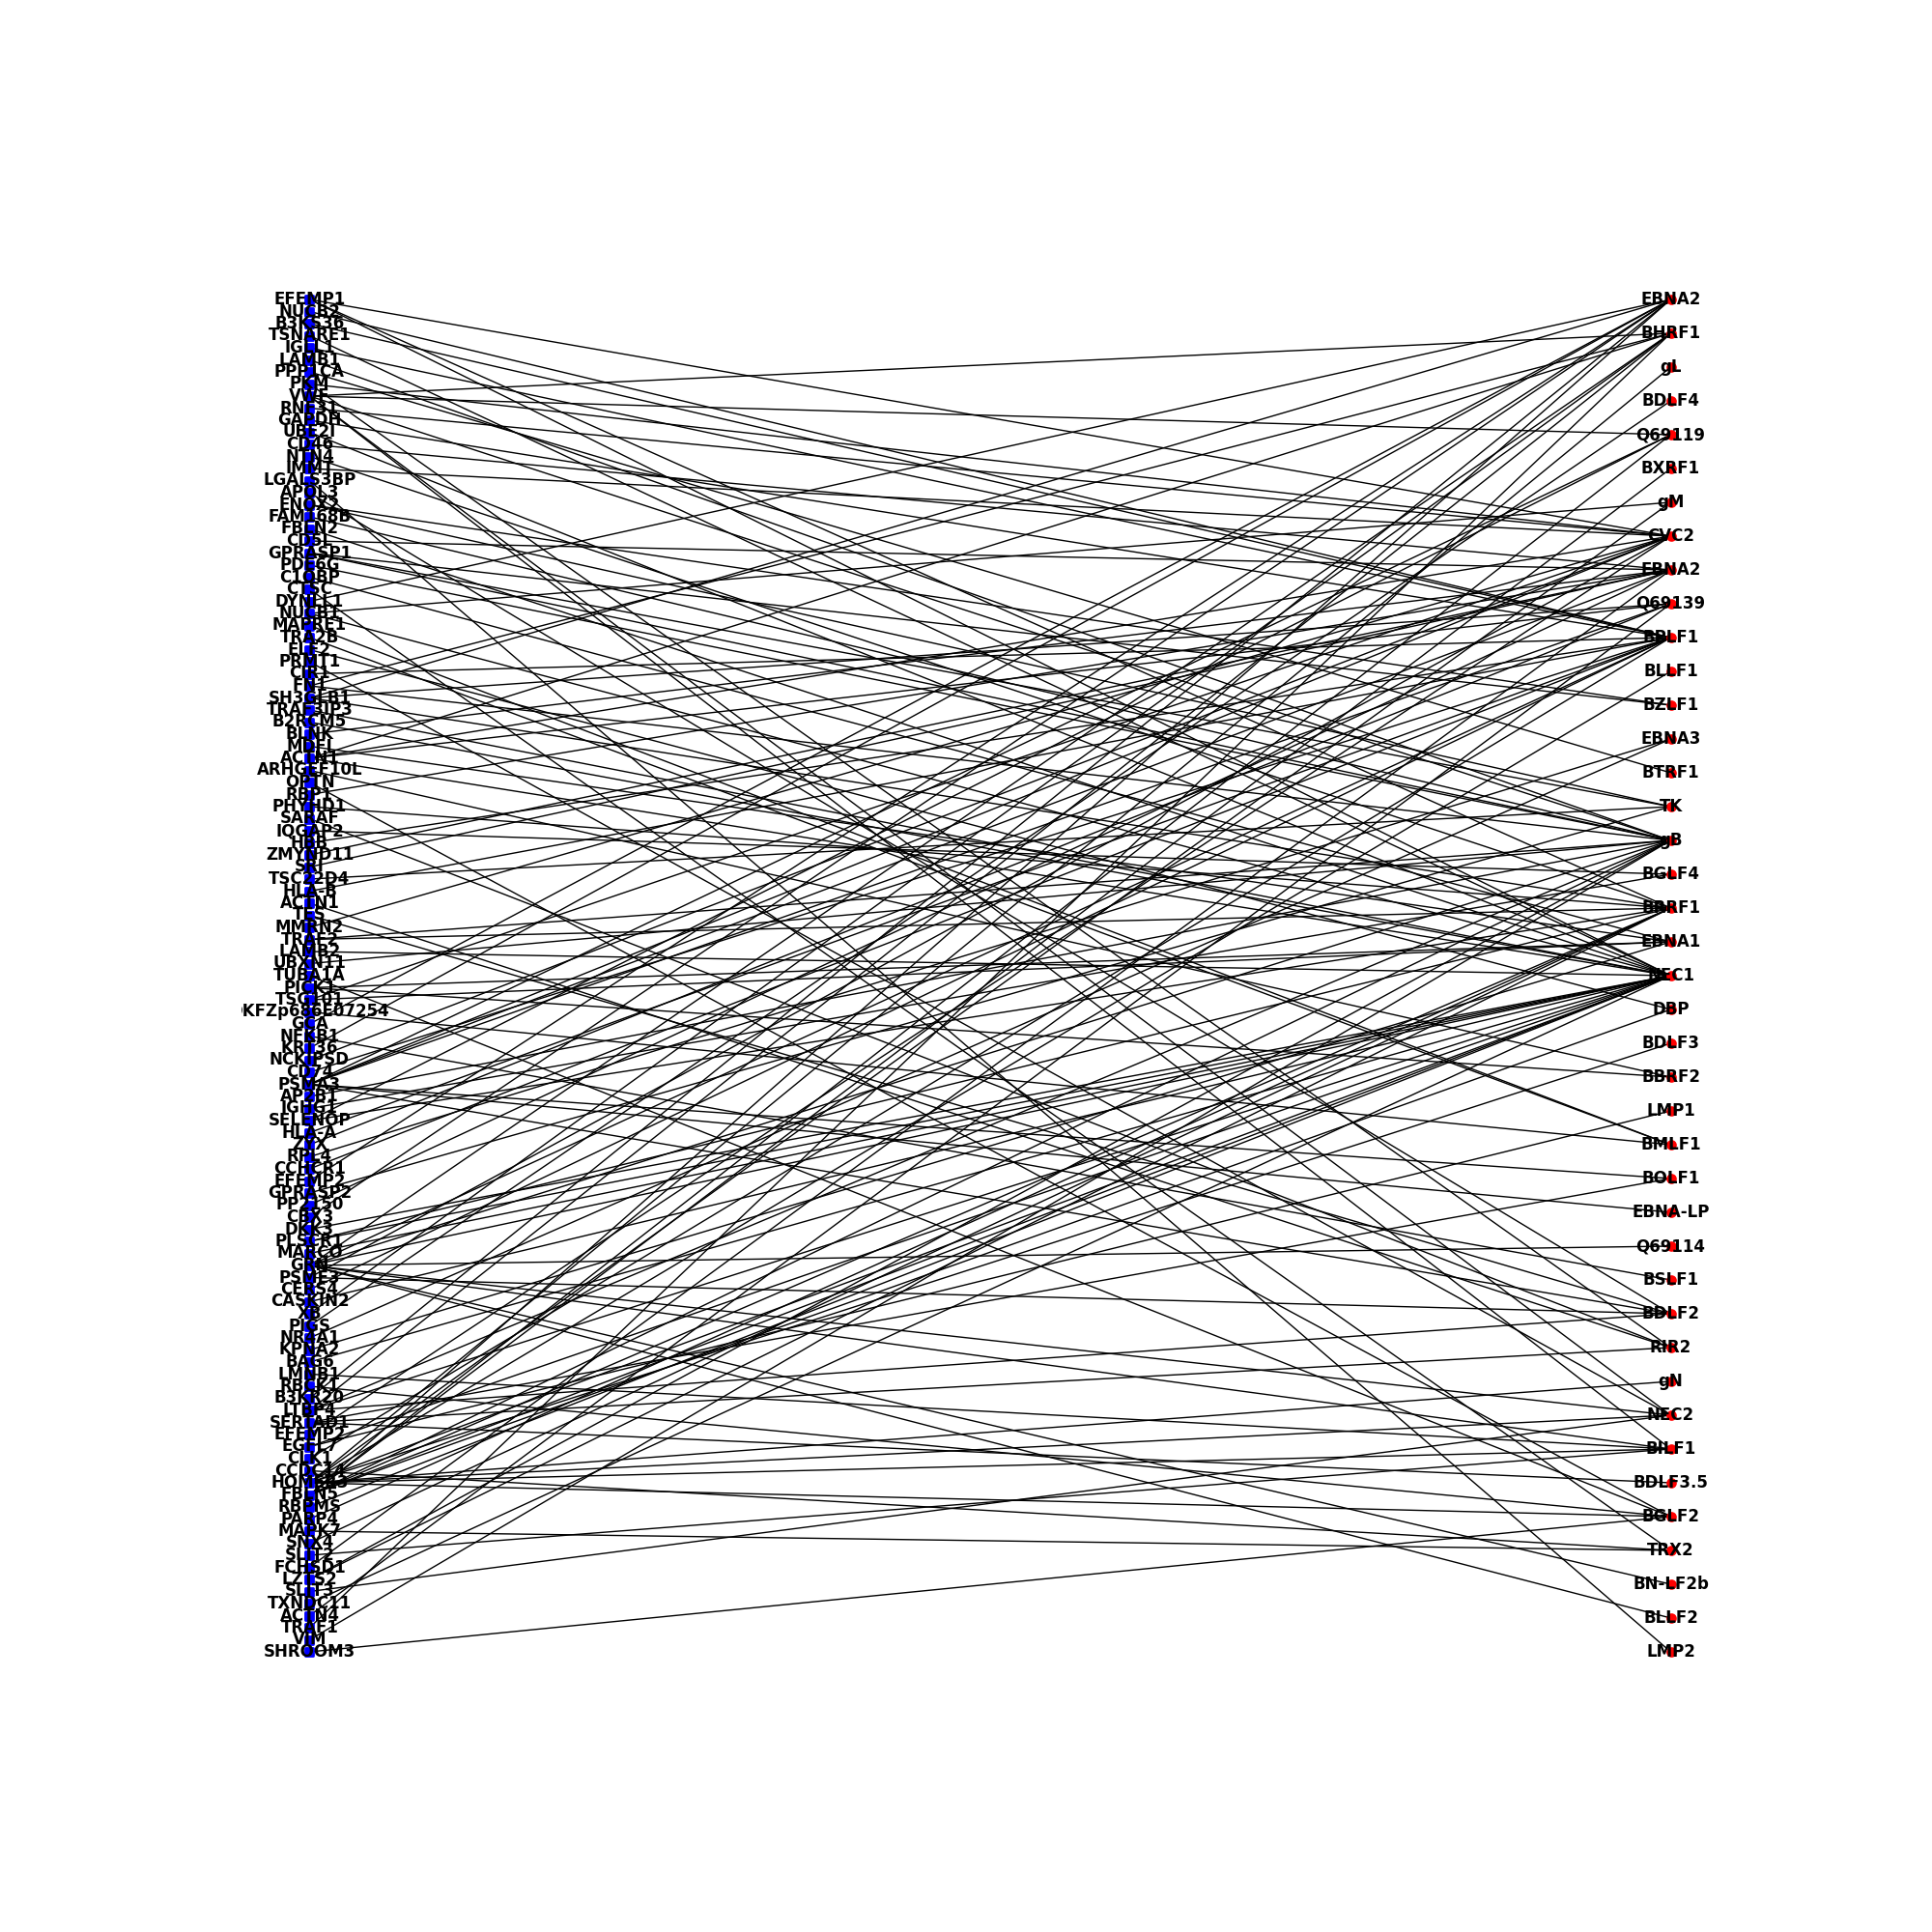

In [64]:
plt.figure(figsize=(10, 10))
plt.axis('off')


X, Y = nx.bipartite.sets(G2, humanGeneLabels.keys())
pos = nx.bipartite_layout(G2, X)

allGeneLabels = {}
allGeneLabels.update(humanGeneLabels)
allGeneLabels.update(ebvGeneLabels)

nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="blue", node_shape="s",nodelist=humanGeneLabels.keys() )
nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="red", node_shape="o",nodelist=ebvGeneLabels.keys() )
nx.draw_networkx_labels(G2,pos,allGeneLabels,font_size=6,font_weight=800,font_color='black')
nx.draw_networkx_edges(G2, pos, width=0.5)

In [66]:
import json

nodes = [{'name': str(i),
          'id': humanGeneLabels[i] if i in humanGeneLabels else ebvGeneLabels[i],
          'type' : 'Human' if i in humanGeneLabels.keys() else 'EBV',
          'weight':G2.degree(i)
         }
         for i in G2.nodes()
        ]

links = []
for a,b in G2.edges() :
   # print(a,b)
    _ = { "source" : None, "target" : None }
    
    for i, n in enumerate(nodes):
        if n['name'] == a:
            _["source"] = i
        elif n['name'] == b:
            _["target"] = i
    if  _["source"] is None or _["target"] is None:
        print(_)
        raise ValueError(a,b)
    
    links.append(_)
         
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)
    

In [74]:
%%html
<div id="d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [76]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "https://d3js.org/d3.v6.min.js"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // Create scale for node radius
  let rMin = 3, rMax = 12;
  let degMin = 1, degMax = 0;

    
  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.
    console.log("Loading JSON")
    // We load the nodes and links in the
    // force-directed graph.
    console.dir(graph);
    force.nodes(graph.nodes);
    console.log("nodes loaded");
    force.links(graph.links)
    console.log("links loaded");
   
    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      //.attr("r", 5)  // radius
      .style("fill", function(d) {
          return  d.type === "EBV" ? "firebrick" : "steelblue"
      }).each(function(d) {
          degMax = d.weight > degMax ? d.weight : degMax;
      })
      .call(force.drag);

      
      let rScale = d3.scale.linear()
          .domain([degMin, degMax]) // unit: km
          .range([rMin,rMax]); // unit: pixels
      node.attr("r", function(d) {
           return rScale(d.weight);
      });  // radius
      
    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
      
    force.start();
    console.log("OK");
  });
});

<IPython.core.display.Javascript object>

## XML data preparation steps
##### Generation of:
* EBV uniprot entries in `Calderwood_EBV_proteome.xml`
* Human uniprot entries in `Calderwood_Human_proteome.xml`

### Get EBV xml Entries
* extract uniprot ID from mitab
* fetch individual uniprot xml
* Collect them in a single `Calderwood_EBV_proteome.xml` file

In [33]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree


#Fetch Xml document from uniprot

EBV_entryName = []
for psqDatum in EBV_psqData:
    EBV_entryName += [ _.replace("uniprotkb:", "") for _ in psqDatum[:2] ]

print(f"{len(EBV_psqData)} EBV-only psq data found {len(set(EBV_entryName))} EBV entries")
for psqDatum in HumanEBV_psqData:
    if re.search(reEBV, psqDatum[9]):
        EBV_entryName.append( psqDatum[0].replace("uniprotkb:", "") )
    elif re.search(reEBV, psqDatum[10]):
        EBV_entryName.append( psqDatum[1].replace("uniprotkb:", "") )
    else :
        raise ValueError(psqDatum)
    
EBV_entryName = set(EBV_entryName)

print(f"{len(EBV_psqData)} EBV-only & {len(HumanEBV_psqData)} EBV-Human psq data found {len(EBV_entryName)} EBV entries")

xmlRawDoc = []
for uniprotID in EBV_entryName:
    xmlRequest=f"https://www.uniprot.org/uniprot/{uniprotID}.xml"
    try:
        httpReq = requests.get(xmlRequest, proxies=proxies)
    except NameError:
        httpReq = requests.get(xmlRequest)

    xmlRawDoc.append(httpReq.text)


59 EBV-only psq data found 48 EBV entries
59 EBV-only & 173 EBV-Human psq data found 64 EBV entries


In [34]:
register_namespace('', "http://uniprot.org/uniprot")
ns = '{http://uniprot.org/uniprot}'
collectionHolder = '<?xml version="1.0" encoding="UTF-8"?>\n<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd"></uniprot>'
collection = fromstring(collectionHolder)

for _ in xmlRawDoc:
    tree = fromstring(_)
    collection.append(tree.find(ns+"entry"))

    _= f"{ns}entry"
print( f"initial number of xml document {len(xmlRawDoc)} found {len( collection.findall(_))} uniprot entries")
tree = ElementTree(collection)
tree.write("./data/Calderwood_EBV_proteome.xml")

initial number of xml document 64 found 64 uniprot entries


### Get Human xml Entries
* extract uniprot ID from mitab
* fetch individual uniprot xml
* Collect them in a single `Calderwood_Human_proteome.xml` file


In [55]:
humanEntryName = []
for psqDatum in HumanEBV_psqData:   
    if re.search(reHuman, psqDatum[9]):
        humanEntryName.append( psqDatum[0].replace("uniprotkb:", "") if  psqDatum[0].startswith("uniprotkb:") else  psqDatum[2].replace("uniprotkb:", ""))
    elif re.search(reHuman, psqDatum[10]):
         humanEntryName.append( psqDatum[1].replace("uniprotkb:", "") if  psqDatum[1].startswith("uniprotkb:") else  psqDatum[3].replace("uniprotkb:", ""))
    else :
        raise ValueError(psqDatum)
    if humanEntryName[-1] == '-': # Two mappings to uniprot are incorrect, we would need to go through gene name to rescue them
        humanEntryName = humanEntryName[:-1]

humanEntryName = set(humanEntryName)

print(f"{len(HumanEBV_psqData)} EBV-Human psq data found {len(humanEntryName)} human entries")

xmlRawDoc = []
for uniprotID in humanEntryName:
    xmlRequest=f"https://www.uniprot.org/uniprot/{uniprotID}.xml"
    try:
        httpReq = requests.get(xmlRequest, proxies=proxies)
    except NameError:
        httpReq = requests.get(xmlRequest)

    xmlRawDoc.append(httpReq.text)


173 EBV-Human psq data found 113 human entries


In [57]:
register_namespace('', "http://uniprot.org/uniprot")
ns = '{http://uniprot.org/uniprot}'
collectionHolder = '<?xml version="1.0" encoding="UTF-8"?>\n<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd"></uniprot>'
collection = fromstring(collectionHolder)

for _, n in zip(xmlRawDoc, humanEntryName):
#    print(n,"-->", _)
    tree = fromstring(_)
    collection.append(tree.find(ns+"entry"))

    _= f"{ns}entry"
print( f"initial number of xml document {len(xmlRawDoc)} found {len( collection.findall(_))} uniprot entries")
tree = ElementTree(collection)
tree.write("./data/Calderwood_Human_proteome.xml")

initial number of xml document 113 found 113 uniprot entries
